In [21]:
from helper import collect_confusion_set_frequencies, extract_word_statistics

import os
import pandas as pd
import spacy

# Update Confusion Sets

In [22]:
from transformers import AutoTokenizer
from helper import check_token

checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

file_name = 'input/confusion_sets_modified.csv'

if not os.path.exists(file_name):
    with open('input/confusion_sets.csv') as f:
        confusion_sets = f.readlines()

        for confusion_set in confusion_sets:
            words = [item.strip() for item in confusion_set.split(',')]
            words.extend([item.capitalize() for item in words])
            words = sorted([item for item in set(words) if check_token(tokenizer, item) is not None])
            if len(words) > 2 or len(words) == 2 and words[0].lower() != words[1].lower():
                with open(file_name, 'a') as nf:
                    nf.write(','.join(sorted(words)) + '\n')
            else:
                print(f'No partners for {confusion_set.strip()}. Resulting set is {words}')


In [23]:
confusion_set_strings = []
word_list = []
nlp = spacy.load('en_core_web_sm')

with open('input/confusion_sets_modified.csv', 'r') as f:
    for line in f.readlines():
        confusion_set = line.strip()
        word_list.extend(confusion_set.split(','))
        confusion_set_strings.append(confusion_set)

# Extract masked sentences from News corpus

In [24]:
item_by_confusion_set = dict()
with open('input/confusion_sets_modified.csv', 'r') as f:
    for line in f.readlines():
        for key in line.strip().split(','):
            item_by_confusion_set[key] = line.strip()

item_by_confusion_set

{'Except': 'Except,accept,except',
 'accept': 'Except,accept,except',
 'except': 'Except,accept,except',
 'advice': 'advice,advise',
 'advise': 'advice,advise',
 'Effect': 'Effect,affect,effect',
 'affect': 'Effect,affect,effect',
 'effect': 'Effect,affect,effect',
 'Being': 'Being,begin,being',
 'begin': 'Being,begin,being',
 'being': 'Being,begin,being',
 'bitch': 'bitch,pitch',
 'pitch': 'bitch,pitch',
 'brakes': 'brakes,breaks',
 'breaks': 'brakes,breaks',
 'Capital': 'Capital,Capitol,capital',
 'Capitol': 'Capital,Capitol,capital',
 'capital': 'Capital,Capitol,capital',
 'Site': 'Site,sight,site',
 'sight': 'Site,sight,site',
 'site': 'Site,sight,site',
 'Country': 'Country,County,country,county',
 'County': 'Country,County,country,county',
 'country': 'Country,County,country,county',
 'county': 'Country,County,country,county',
 'crab': 'crab,crap',
 'crap': 'crab,crap',
 'Desert': 'Desert,desert,dessert',
 'desert': 'Desert,desert,dessert',
 'dessert': 'Desert,desert,dessert',
 '

In [25]:
file_name = 'input/eng_news_2023_10K-masked-sentences.csv'

if not os.path.exists(file_name):
    input_file = open('input/eng_news_2023_10K-sentences.txt', 'r')

    with open(file_name, 'w') as f:
        print('confusion_set', 'target', 'masked_sentence', sep='\t', end='\n', file=f)
        for line in input_file.readlines():
            _, sentence = line.strip().split('\t')
            doc = nlp(sentence)
            for token in doc:
                if token.text in item_by_confusion_set.keys():
                    end = token.idx + len(token.text)
                    masked_sentence = sentence[:token.idx] + '[MASK]' + sentence[end:]
                    print(item_by_confusion_set[token.text], token.text, masked_sentence, sep='\t', end='\n', file=f)

    input_file.close()

#### Analysis of news data set

In [26]:
file_name = 'output/report_word_statistics_10k_23.csv'

if not os.path.isfile(file_name):
    org_file_name = 'input/eng_news_2023_10K-sentences.txt'
    temp_df = extract_word_statistics(org_file_name, nlp, word_list)
    temp_df['frequency'] =temp_df['sentence_indices'].apply(lambda x: len(x.split(',')) if type(x) == str and len(x) > 1 else 0)
    temp_df.sort_values(by=['word']).to_csv(file_name, index=False, mode='w', sep=';')
else:
    temp_df = pd.read_csv(file_name, sep=';')

temp_df

,word,sentence_indices,frequency
0,Being,1145,1
1,Capital,"357,962,1209,1526,1714,2135,2233,2235,2243,224...",23
2,Capitol,"909,6706",2
3,Country,"47,4468,7640,8210,8210,8210,9019",7
4,County,"641,689,880,880,1028,1184,1662,1725,1813,1925,...",34
...,...,...,...
162,with,"6,11,19,28,29,30,32,33,36,65,69,87,113,120,123...",1491
163,word,"323,807,867,1480,2894,3561,3703,3717,4425,4642...",20
164,world,"87,124,158,387,477,496,567,814,913,1064,1084,1...",102
165,you,"16,43,63,63,128,128,128,185,200,222,222,230,28...",637


In [27]:
collection = []
for x in list(temp_df['sentence_indices']):
    if type(x) == str:
        collection.extend(x.split(','))

len(set(collection)) # equals number of sentences used from the original data set

7344

<Axes: title={'center': 'confusion set frequency distribution of 10k data set'}>

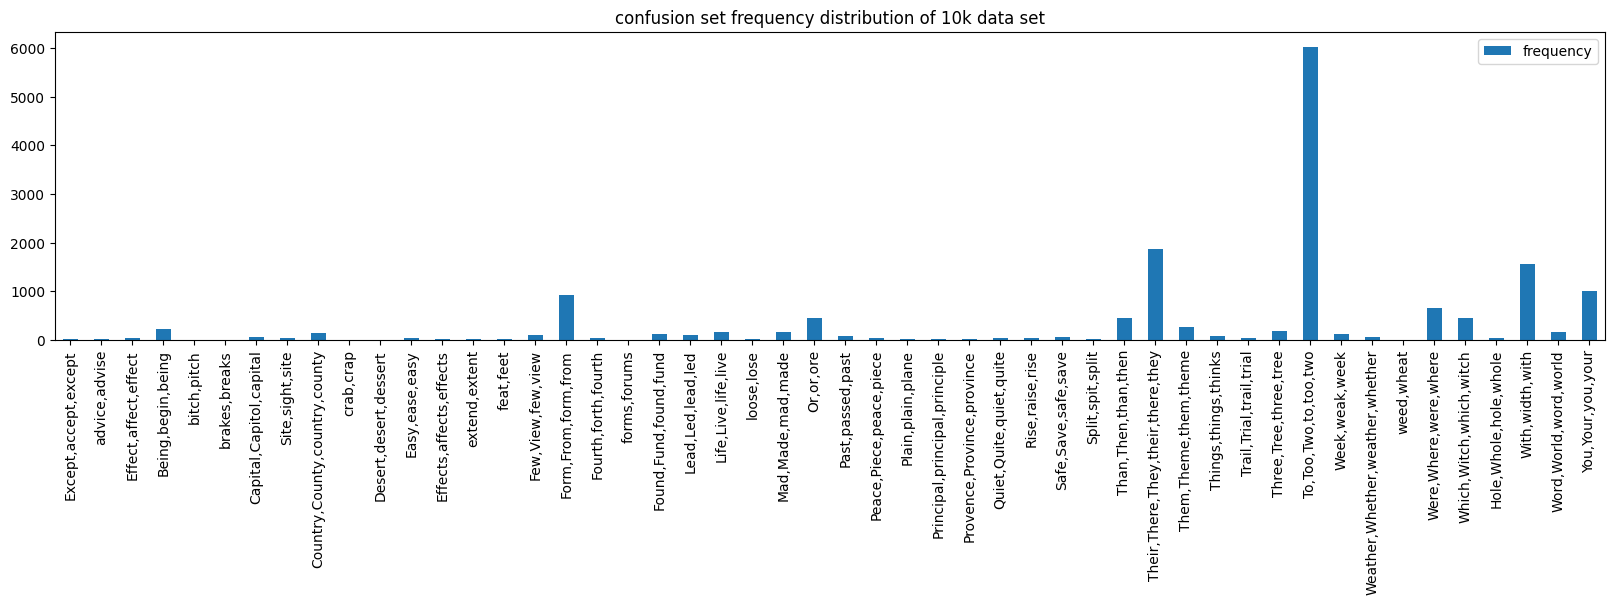

In [28]:
df_10k = collect_confusion_set_frequencies(temp_df, confusion_set_strings)
df_10k['frequency %'] = df_10k['frequency'].apply(lambda x: x / df_10k['frequency'].max())
df_10k.plot(y='frequency', kind="bar", figsize=(20,4), title='confusion set frequency distribution of 10k data set')

In [29]:
df_10k.frequency.sum()

np.int64(15960)

In [30]:
df_10k.sort_values(by='frequency', ascending=False, inplace=True)
df_10k['frequency'].to_latex()

'\\begin{tabular}{lr}\n\\toprule\n & frequency \\\\\n\\midrule\nTo,Too,Two,to,too,two & 6034 \\\\\nTheir,There,They,their,there,they & 1860 \\\\\nWith,width,with & 1556 \\\\\nYou,Your,you,your & 998 \\\\\nForm,From,form,from & 919 \\\\\nWere,Where,were,where & 650 \\\\\nOr,or,ore & 454 \\\\\nThan,Then,than,then & 446 \\\\\nWhich,Witch,which,witch & 443 \\\\\nThem,Theme,them,theme & 261 \\\\\nBeing,begin,being & 231 \\\\\nThree,Tree,three,tree & 184 \\\\\nWord,World,word,world & 167 \\\\\nLife,Live,life,live & 166 \\\\\nMad,Made,mad,made & 157 \\\\\nCountry,County,country,county & 145 \\\\\nWeek,weak,week & 131 \\\\\nFound,Fund,found,fund & 129 \\\\\nFew,View,few,view & 109 \\\\\nLead,Led,lead,led & 97 \\\\\nPast,passed,past & 81 \\\\\nThings,things,thinks & 70 \\\\\nWeather,Whether,weather,whether & 66 \\\\\nSafe,Save,safe,save & 53 \\\\\nCapital,Capitol,capital & 52 \\\\\nQuiet,Quite,quiet,quite & 39 \\\\\nFourth,forth,fourth & 37 \\\\\nRise,raise,rise & 36 \\\\\nHole,Whole,hole,whole

# Balancing

#### Analysis of 1M news corpus

In [31]:
file_name = 'output/report_word_statistics_1M_23.csv'

if not os.path.isfile(file_name):
    # requires eng_news_2023_1M.tar.gz from https://wortschatz.uni-leipzig.de/en/download/English
    org_file_name = 'input/eng_news_2023_1M-sentences.txt'
    temp_df = extract_word_statistics(org_file_name, nlp, word_list)
    temp_df['frequency'] =temp_df['sentence_indices'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)
    temp_df.sort_values(by=['word']).to_csv(file_name, index=False, mode='w', sep=';')
else:
    temp_df = pd.read_csv(file_name, sep=';')

temp_df

,word,sentence_indices,frequency
0,Except,"187686,214438,214439,214440,214441,214442,2144...",86
1,accept,"1446,1461,4711,5129,6646,8918,9916,10292,12969...",847
2,except,"3982,4342,10214,10318,11689,11823,12423,13585,...",566
3,advice,"3166,4758,7965,9957,10446,10849,11056,11134,12...",1173
4,advise,"4106,4169,9807,22973,27943,31831,32667,37323,3...",202
...,...,...,...
162,world,"188,191,525,545,684,1085,1125,1164,1520,1538,1...",10865
163,You,"150,1114,1576,2179,2248,2759,3853,4420,6899,75...",9600
164,Your,"3422,5172,5196,8396,8396,9735,11179,11737,1198...",1333
165,you,"6,41,81,92,93,106,115,153,170,206,268,286,340,...",63344


<Axes: title={'center': 'confusion set frequencies of 1M data set'}>

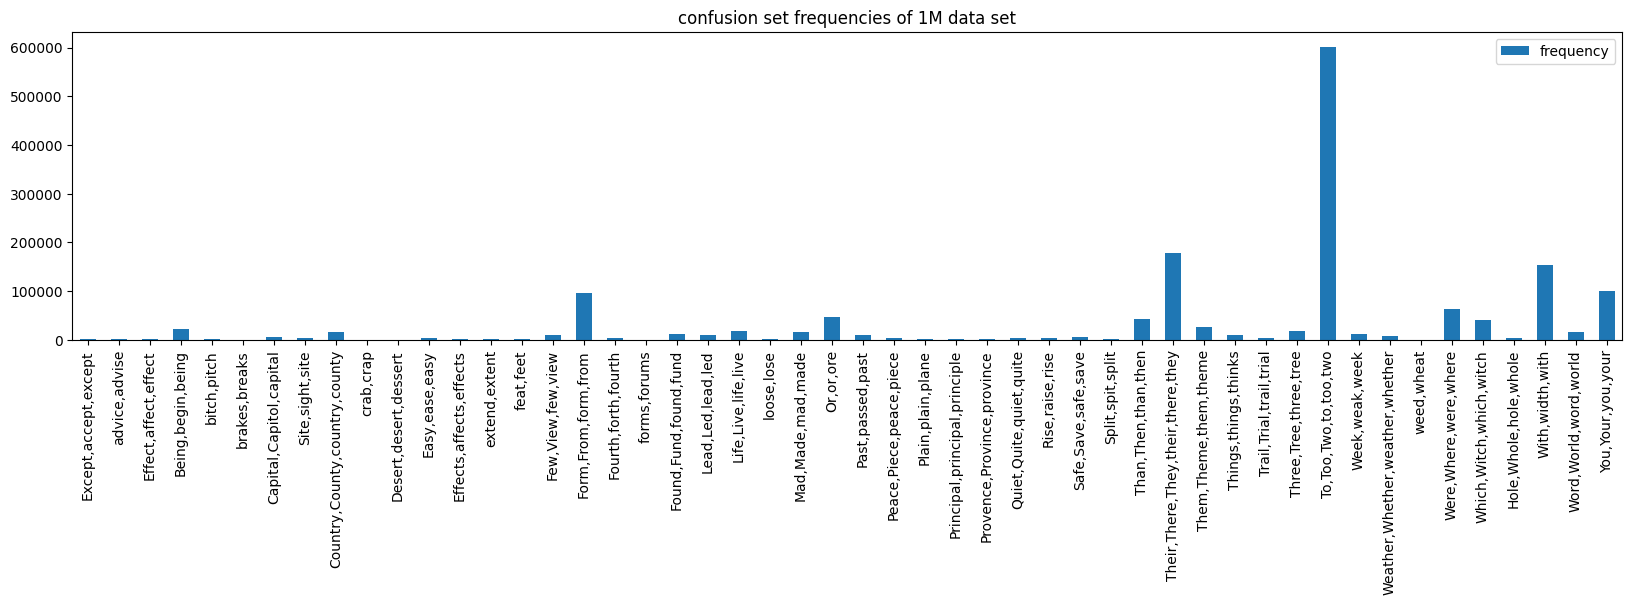

In [32]:
df_1M = collect_confusion_set_frequencies(temp_df, confusion_set_strings)
df_1M['frequency %'] = df_1M['frequency'].apply(lambda x: x / df_1M['frequency'].max())
df_1M.plot(y='frequency', kind="bar", figsize=(20,4), title="confusion set frequencies of 1M data set")

#### Create Balanced-News Corpus

In [33]:
file_name = 'output/report_word_statistics_balanced.csv'

balanced_dict = dict()
limit = 100

if not os.path.isfile(file_name):

    with open(file_name, 'w') as f:
        word_frequencies = pd.read_csv('output/report_word_statistics_1M_23.csv', index_col=0, sep=';')

        for item in word_frequencies.index:
            indices = word_frequencies.loc[item]['sentence_indices']
            balanced_dict[item] = sorted(int(idx) for idx in indices.split(','))[:100]

        for key in sorted(balanced_dict.keys()):
            print(key, ','.join([str(item) for item in balanced_dict[key]]), file=f, end='\n', sep='\t')

else:
    with open(file_name, 'r') as f:
        for line in f.readlines():
            key, value = line.strip().split('\t')
            balanced_dict[key] = [int(idx) for idx in value.split(',')]

for key,value in balanced_dict.items():
    if len(value) < limit:
        print(key,len(value))

Easy 79
Effect 52
Effects 22
Except 86
Found 41
Hole 46
Led 85
Mad 66
Past 69
Piece 93
Plain 42
Provence 11
Quiet 62
Quite 69
Site 85
Split 28
Than 53
Them 42
Theme 16
Trial 65
Whole 64
Witch 85
bitch 32
brakes 55
crab 65
crap 58
forums 85
ore 76
spit 57
width 65


In [34]:
count = 0
for key,value in balanced_dict.items():
    if len(value) < limit:
        count += 1
print(f'number of undersampled words: {count}')

number of undersampled words: 30


In [36]:
file_name = 'input/eng_news_2023_balanced-masked-sentences.csv'


if not os.path.isfile(file_name):

    def mask_sentence(token_text, tmp_sentence):
        tmp_doc = nlp(tmp_sentence)
        for tmp_token in tmp_doc:
            if tmp_token.text == token_text:
                end = tmp_token.idx + len(tmp_token.text)
                return tmp_sentence[:tmp_token.idx] + '[MASK]' + tmp_sentence[end:]

    dict_sentences = dict()
    with open('input/eng_news_2023_balanced-sentences.csv', 'r') as input_file:
        for line in input_file.readlines():
            key, value = line.strip().split('\t')
            dict_sentences[int(key)] = value

    with open(file_name, 'w') as f:
        print('confusion_set', 'target', 'masked_sentence', sep='\t', end='\n', file=f)
        for confusion_set in confusion_set_strings:
            for item in confusion_set.split(','):
                for idx in balanced_dict[item]:
                    result = mask_sentence(item, dict_sentences[idx])
                    print(confusion_set, item, result, sep='\t', end='\n', file=f)

balanced_data = pd.read_csv(file_name, sep=r'\t', engine='python')
balanced_data.head()

,confusion_set,target,masked_sentence
0,"Except,accept,except",Except,DISCLOSURE NOTICE: [MASK] where otherwise note...
1,"Except,accept,except",Except,"[MASK] agriculture, milling is the oldest indu..."
2,"Except,accept,except",Except,"[MASK] Alwin, the other three are engineering ..."
3,"Except,accept,except",Except,[MASK] — and here’s what I think I responded t...
4,"Except,accept,except",Except,[MASK] as required under applicable securities...


<Axes: xlabel='confusion_set'>

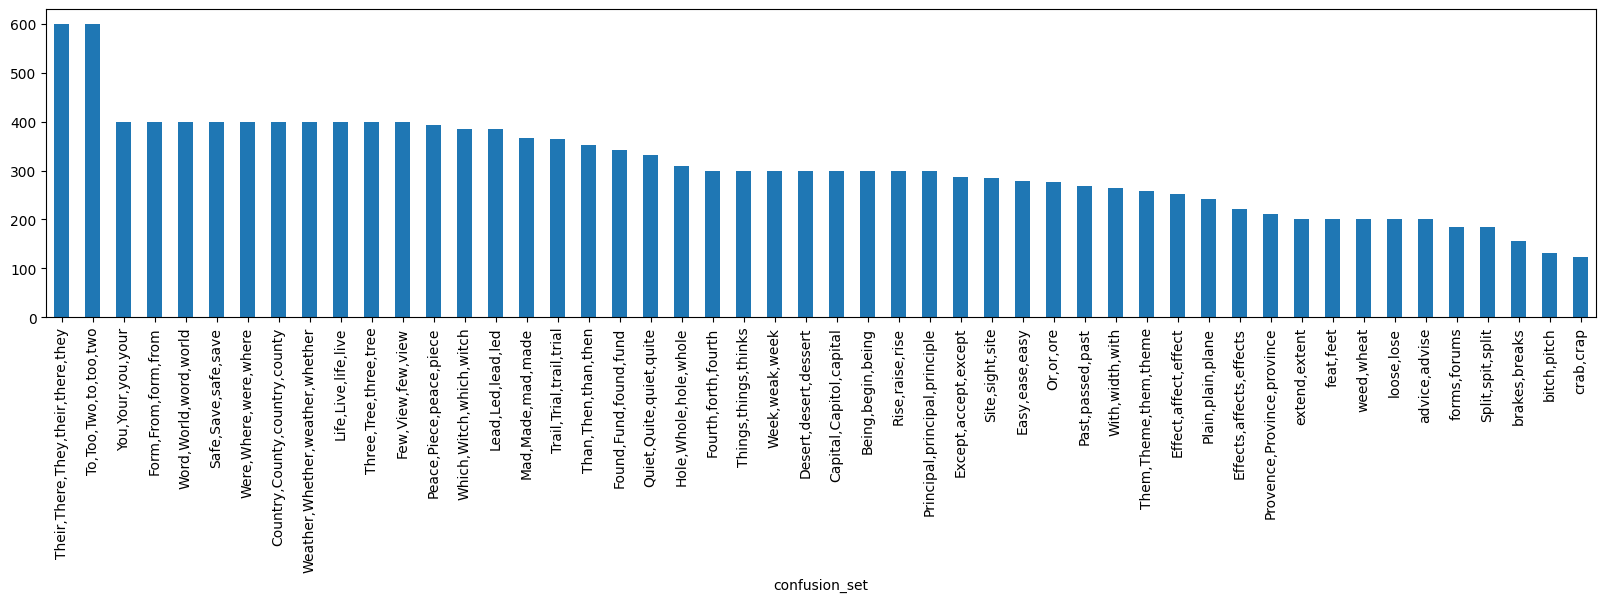

In [37]:
balanced_data['confusion_set'].value_counts().plot.bar(rot=90, figsize=(20,4))